In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier
import models

import matplotlib.pyplot as plt
from itertools import product

/Users/treycole/Codes/WanPy/dev notebooks


In [8]:
def wf_dpr(wf1, wf2):
    """calculate dot product between two wavefunctions.
    wf1 and wf2 are of the form [orbital,spin]"""
    return np.dot(wf1.flatten().conjugate(), wf2.flatten())


def berry_loop(wf, berry_evals=False):
    """Do one Berry phase calculation (also returns a product of M
    matrices).  Always returns numbers between -pi and pi.  wf has
    format [kpnt,band,orbital,spin] and kpnt has to be one dimensional.
    Assumes that first and last k-point are the same. Therefore if
    there are n wavefunctions in total, will calculate phase along n-1
    links only!  If berry_evals is True then will compute phases for
    individual states, these corresponds to 1d hybrid Wannier
    function centers. Otherwise just return one number, Berry phase."""
    # number of occupied states
    nocc = wf.shape[1]
    # temporary matrices
    prd = np.identity(nocc, dtype=complex)
    ovr = np.zeros([nocc, nocc], dtype=complex)
    # go over all pairs of k-points, assuming that last point is overcounted!
    for i in range(wf.shape[0]-1):
        # generate overlap matrix, go over all bands
        for j in range(nocc):
            for k in range(nocc):
                # ovr[j,k] = wf_dpr(wf[i,j,:], wf[i+1,k,:])
                ovr[j,k] = np.vdot(wf[i,j,:], wf[i+1,k,:])

        # only find Berry phase
        if not berry_evals:
            # multiply overlap matrices
            prd = np.dot(prd, ovr)
        # also find phases of individual eigenvalues
        else:
            # cleanup matrices with SVD then take product
            matU, sing, matV = np.linalg.svd(ovr)
            prd = np.dot(prd, np.dot(matU, matV))
    # calculate Berry phase
    if not berry_evals:
        det = np.linalg.det(prd)
        pha = (-1.0)*np.angle(det)
        return pha
    # calculate phases of all eigenvalues
    else:
        evals = np.linalg.eigvals(prd)
        eval_pha = (-1.0)*np.angle(evals)
        # sort these numbers as well
        eval_pha = np.sort(eval_pha)
        return eval_pha


def berry_flux_plaq(bloch_wfs, state_idx=None):
    "Compute fluxes on a two-dimensional plane of states."
    wfs = bloch_wfs.get_states()["Cell periodic"]
    orb_vecs = bloch_wfs.model._orb_vecs
    # size of the mesh
    nks = bloch_wfs.K_mesh.nks
    nk0 = wfs.shape[0]
    nk1 = wfs.shape[1]

    # here store flux through each plaquette of the mesh
    all_phases = np.zeros((nk0, nk1), dtype=float)

    if state_idx is not None:
        wfs = np.take(wfs, state_idx, axis=-2)

    # go over all plaquettes
    for i in range(nk0):
        for j in range(nk1):
            # generate a small loop made out of four pieces
            wf_use = [wfs[i, j]]

            nbrs = [[i+1, j], [i+1, j+1], [i, j+1]]
            for nbr in nbrs:
                mod_idx = np.mod(nbr, nks) # apply pbc to index
                wf_nbr = np.copy(wfs[tuple(mod_idx)]) # copy to prevent modifying original array

                diff = nbr - mod_idx # if mod changed nbr, will be non-zero
                if np.any(diff):
                    G = np.divide(np.array(diff), np.array(nks)) # will be pm 1 where crossed, 0 else
                    phase = np.exp(-2j * np.pi * G @ orb_vecs.T)#.T
                    wf_nbr *= phase[np.newaxis, ...]
                
                wf_use.append(wf_nbr)
            
            wf_use.append(wfs[i, j])
            wf_use = np.array(wf_use, dtype=complex)
            # calculate phase around one plaquette
            all_phases[i, j] = berry_loop(wf_use)

    return all_phases


def get_Omega_I_k(P, Q_nbr, k_mesh):
    nks = P.shape[:2]
    Nk = np.prod(nks)
    num_nnbrs = Q_nbr.shape[2]
    w_b, _, idx_shell = k_mesh.get_weights(N_sh=1)

    T_kb = np.zeros((*nks, num_nnbrs), dtype=complex)
    for idx, idx_vec in enumerate(idx_shell[0]):  # nearest neighbors
        T_kb[..., idx] = np.trace(P[..., :, :] @ Q_nbr[..., idx, :, :], axis1=-1, axis2=-2)

    return (1 / Nk) * w_b[0] * np.sum(T_kb, axis=-1)


def get_Omega_til(M, w_b, k_shell):
        nks = M.shape[:-3]
        Nk = np.prod(nks)
        k_axes = tuple([i for i in range(len(nks))])

        diag_M = np.diagonal(M, axis1=-1, axis2=-2)
        log_diag_M_imag = np.log(diag_M).imag
        abs_diag_M_sq = abs(diag_M) ** 2

        r_n = -(1 / Nk) * w_b * np.sum(log_diag_M_imag, axis=k_axes).T @ k_shell

        Omega_tilde = (1 / Nk) * w_b * ( 
                np.sum((-log_diag_M_imag - k_shell @ r_n.T)**2) + 
                np.sum(abs(M)**2) - np.sum(abs_diag_M_sq)
            )
        return Omega_tilde


def interp_op(O_k, k_path, mesh, plaq=False):
    nks = mesh.nks
    k_idx_arr = mesh.idx_arr

    if plaq:
        k_mesh = mesh.full_mesh + np.array([(1/nk)/2 for nk in nks])
    else:
        k_mesh = mesh.full_mesh
    
    Nk = np.prod([nks])
    
    # Fourier transform to real space
    supercell = list(product(*[range(-int((nk-nk%2)/2), int((nk-nk%2)/2)) for nk in nks]))
    O_R = np.zeros((len(supercell), *O_k.shape[2:]), dtype=complex)
    for idx, (x, y) in enumerate(supercell):
        for kx in range(O_k.shape[0]):
            for ky in range(O_k.shape[1]):
                R_vec = np.array([x, y])
                phase = np.exp(-1j * 2 * np.pi * np.vdot(k_mesh[kx, ky], R_vec))
                O_R[idx] += O_k[kx, ky] * phase / Nk

    # interpolate to arbitrary k
    O_k_interp = np.zeros((k_path.shape[0], *O_R.shape[2:]), dtype=complex)
    for k_idx, k in enumerate(k_path):
        for idx, (x, y) in enumerate(supercell):
            R_vec = np.array([x, y])
            phase = np.exp(1j * 2 * np.pi * np.vdot(k, R_vec))
            O_k_interp[k_idx] += O_R[idx] * phase

    return O_k_interp

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


(<Figure size 640x480 with 2 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

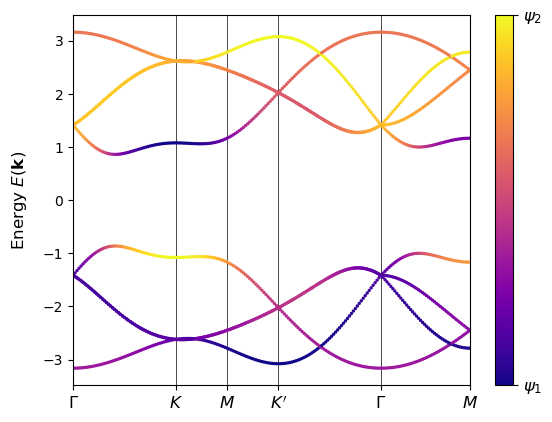

In [3]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.4

n_super_cell = 2
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

#############

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

nkx, nky = 10, 10
u_wfs_2d = wf_array(model, [nkx, nky])
u_wfs_2d.solve_on_grid([0, 0])
berry_flux = u_wfs_2d.berry_flux([i for i in range(n_occ)], individual_phases=True)
chern = u_wfs_2d.berry_flux([i for i in range(n_occ)])/(2*np.pi)

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

model.plot_bands(k_path, k_label=k_label, nk=201, scat_size=2, red_lat_idx=high_E_sites, cmap='plasma')

In [4]:
# k_mesh = K_mesh(model, nkx-1, nky-1)
# full_mesh = k_mesh.gen_k_mesh(endpoint=False)
# full_mesh_mat = k_mesh.gen_k_mesh(flat=False, endpoint=False)
# recip_lat_vecs = model.get_recip_lat_vecs()
# mesh_Cart = full_mesh_mat @ recip_lat_vecs

# KX = mesh_Cart[:, :, 0]
# KY = mesh_Cart[:, :, 1]

# im = plt.pcolormesh(KX, KY, berry_flux, cmap='plasma', shading='gouraud', vmin=0, vmax=0.035)
# plt.colorbar(label=r'$\Omega(\mathbf{k})$')

In [5]:
# print(u_wfs[0,0])
# print(u_wfs[0,-1])
# G = np.array([0,1])
# u_wfs_p = np.exp(-2j*np.pi * G @ orb_vecs.T) * u_wfs[0, 0]
# print(u_wfs_p)
# print(np.vdot(u_wfs[0,0], u_wfs_p))

# print("")
# print(u_wfs_2d._wfs[0,0])
# print(u_wfs_2d._wfs[0,-1])
# print(np.vdot(u_wfs_2d._wfs[0,0], u_wfs_2d._wfs[0,-1]))

In [9]:
nk1, nk2 = 20, 20

mesh = K_mesh(model, nk1, nk2)
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

bloch = Bloch(model, nk1, nk2)
bloch.solve_model()
u_wfs = bloch.get_states()["Cell periodic"]
u_occ = u_wfs[..., :n_occ, :]  # occupied energy eigenstates
Bloch_occ = Bloch(model, u_occ.shape[0], u_occ.shape[1])
Bloch_occ.set_wfs(u_occ, cell_periodic=True)

Berry_curv = Bloch_occ.berry_flux_plaq()
Berry_curv_path = interp_op(Berry_curv, k_vec, mesh, plaq=True)
omega_i_k = Bloch_occ.trace_metric()[..., np.newaxis]
omega_i_k_path = Bloch_occ.interp_op(omega_i_k, k_vec)

omega_i = np.sum(omega_i_k)
# print(np.sum(berry_flux_plaq(bloch, state_idx=np.arange(n_occ))/(2*np.pi)))

In [195]:
k_mesh = K_mesh(model, nk1, nk2)
k_mesh.full_mesh[0,1]

array([0.  , 0.05])

In [197]:
new_mesh = k_mesh.full_mesh + np.array([(1/nk1)/2, (1/nk2)/2])

new_mesh[0,0]

array([0.025, 0.025])

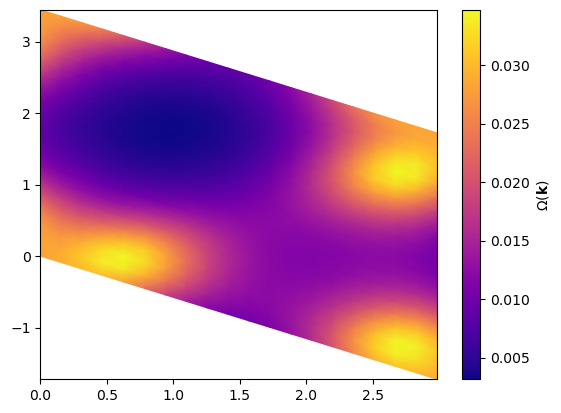

In [181]:
k_mesh = K_mesh(model, nk1, nk2)
full_mesh = k_mesh.gen_k_mesh(endpoint=False)
full_mesh_mat = k_mesh.gen_k_mesh(flat=False, endpoint=False)
recip_lat_vecs = model.get_recip_lat_vecs()
mesh_Cart = full_mesh_mat @ recip_lat_vecs

KX = mesh_Cart[:, :, 0]
KY = mesh_Cart[:, :, 1]

im = plt.pcolormesh(KX, KY, Berry_curv, cmap='plasma', shading='gouraud')
plt.colorbar(label=r'$\Omega(\mathbf{k})$')

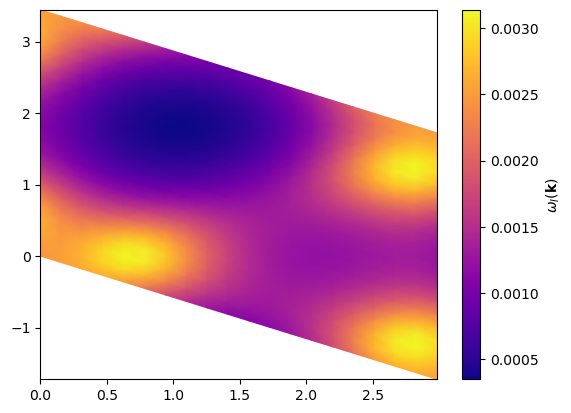

In [182]:
im = plt.pcolormesh(KX, KY, omega_i_k[:,:,0].real, cmap='plasma', shading='gouraud')
plt.colorbar(label=r'$\omega_I(\mathbf{k})$')

Text(0.5, 1.0, 'Traced metric $\\omega_I$')

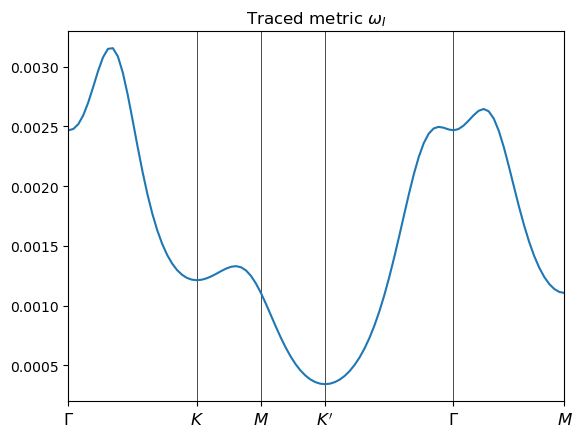

In [183]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.plot(k_dist, omega_i_k_path.real)
ax.set_title(r"Traced metric $\omega_I$")

Text(0.5, 1.0, 'Berry Curvature')

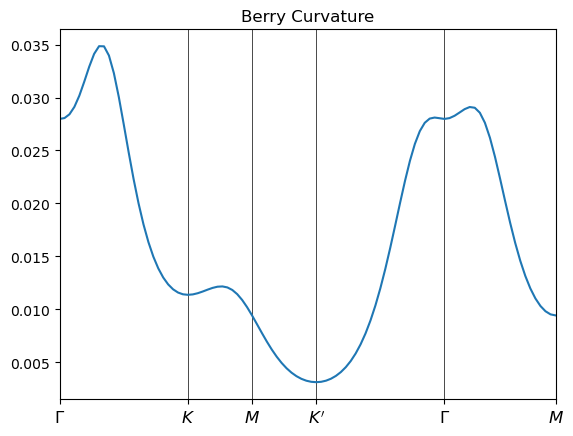

In [10]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.plot(k_dist, Berry_curv_path.real)
ax.set_title("Berry Curvature")

Text(0.5, 1.0, 'Berry Curvature')

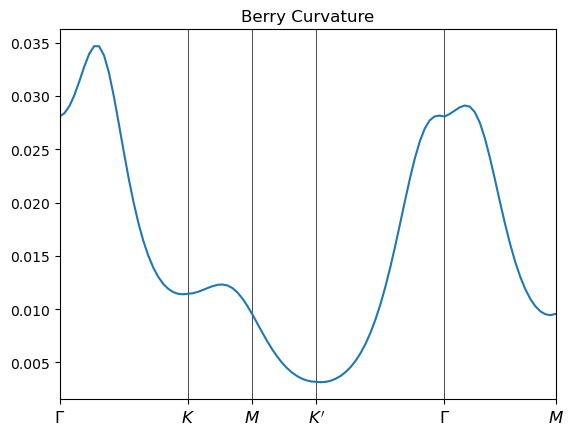

In [184]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.plot(k_dist, Berry_curv_path.real)
ax.set_title("Berry Curvature")